In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import concatenate
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model

In [15]:
# text_df = pd.read_csv('titles.csv')
text_df = pd.read_csv('../dataset/category_wise_data/titles.csv')
text_df = text_df.sample(frac=1).reset_index(drop=True)
print(text_df.shape)
print(text_df.head())

(15188, 4)
      Video Id                                              Title  \
0  lc2h6mBTNYk  Electric Bicycle, Antares Modified 2wd Electri...   
1  mAPeCWUjUCs  CAR CRASH COMBO!  Player #24 Daryl Partington ...   
2  qujsEnJ26SQ  Dallas High's Small Dance & Drill Team Final P...   
3  KXaUP-lOXk8                    WALL STREET: MONEY NEVER SLEEPS   
4  B3y_baAZ66g                      Swansea Crossbar Challenge #2   

                                         Description  Category  
0  Corbin of CorbinFiber and his Antares modified...         1  
1  To submit your footage to Shredit Cards submit...        17  
2  Dallas High School's routine from the 2012 OSA...        17  
3                            IN CINEMAS 23 SEPTEMBER         1  
4                      Swansea Crossbar Challenge #2        17  


In [16]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le = le.fit(text_df['Category'])
print(le.classes_)

category = le.transform(text_df['Category'])
text_df['Category'] = category
print(category)

[ 1  2 10 17]
[0 3 3 ... 2 1 3]


In [4]:
text_df['Combined_text'] = text_df['Title'] + ' ' + text_df['Description'].astype(str)
#text_df = text_df[['Title', 'Category']]
text_df = text_df[['Combined_text', 'Category']]
print(text_df.head())

                                       Combined_text  Category
0  2012 Ram 6.7 Cummins 4" Straight Pipe Exhaust ...         1
1  Foo Fighters Arcade Fire Cover Foo's do a cove...         2
2  Matthew Codek - Aguardiente   house-music-dj-t...         2
3  Real Madrid's Top 10 Historical Goals Real Mad...         3
4  Year 3000 by the Jonas Brothers in High Defini...         2


In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(text_df, test_size=0.2, random_state=42)
train, test = train_test_split(text_df, test_size=0.2)
X_train = train['Combined_text']
#X_train = train['Title']
y_train = train['Category']

#X_test = test['Title']
X_test = test['Combined_text']
y_test = test['Category']

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(12150,)
(12150,)
(3038,)
(3038,)


In [6]:
#tokenizer = Tokenizer(num_words=20000)
tokenizer = Tokenizer(num_words=20000, filters='!"#$%^()*+,-./:;<=>?[\\]^_`{|}~\t\n', lower=True)
#tokenizer = Tokenizer(filters='!"#$%^()*+,-./:;<=>?[\\]^_`{|}~\t\n', lower=True)
#tokenizer.fit_on_texts(text_df['Title'])
tokenizer.fit_on_texts(text_df['Combined_text'])
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test) 

In [7]:
maxlen=500
X_train=pad_sequences(X_train,padding='post', maxlen=maxlen)
X_test=pad_sequences(X_test,padding='post', maxlen=maxlen)
print(str(X_train[0]))

[12976   402   773   582   679   929  2172    87   207     6    53  2128
    33     4   236    87  6632     1    32  3630     2  9712    27    49
    11    57    40    69  1229   321    18   582  9713  1051    87    20
  1538  2173     3  1076   321    18  3261   582   644    87    20  3261
     3  1373     3   845  4255    20  4255    20     1  3261  1076 15905
  2874 10985  2388   615     1 12976     1    32    27    49    69    84
  5515    13     2   918     6     2    98     1   321  1373   149 12977
   202  3500  7895  4255   149    20     1   306    50     1  7895  1368
  4908  6176  2265  3927 12978   380  1374  2795  8745   358  3927     1
    33  1799    20 12976     1   559    20  8745  5515    13     2   918
     6     2    98     1   559    20   889  6633  9714    33    12   127
   200    20 12976     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [8]:
max_features = 20000  # Only consider the top 20k words
# maxlen = 200  # Only consider the first 200 words of each video title

# Input for variable-length sequences of integers
inputs = keras.Input(shape=(None,), dtype="int32")
# Embed each integer in a 128-dimensional vector
x = layers.Embedding(max_features, 128)(inputs)
print(x.shape)
# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.1))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
x = layers.Flatten()(x)
outputs = layers.Dense(4, activation="softmax")(x)
lstm_model = keras.Model(inputs, outputs)
lstm_model.compile(optimizer=SGD
    (learning_rate=0.05, momentum=0.9, nesterov=False),
    loss='sparse_categorical_crossentropy',  # change to categorical with shape[0,0,...1,0,0..] with length as the total number of thumbnail categories
    metrics=['accuracy'])

(None, None, 128)


In [ ]:
X_train

In [ ]:
y_train

In [9]:
checkpoint = ModelCheckpoint("lstm_model2.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=2, verbose=1, mode='auto')
hist = lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, callbacks=[checkpoint, early])

Epoch 1/10
380/380 [==============================] - ETA: 0s - loss: 1.3884 - accuracy: 0.2697
Epoch 00001: val_accuracy improved from -inf to 0.24358, saving model to lstm_model2.h5
380/380 [==============================] - 511s 1s/step - loss: 1.3884 - accuracy: 0.2697 - val_loss: 1.3833 - val_accuracy: 0.2436
Epoch 2/10
380/380 [==============================] - ETA: 0s - loss: 1.2315 - accuracy: 0.3963
Epoch 00002: val_accuracy improved from 0.24358 to 0.50395, saving model to lstm_model2.h5
380/380 [==============================] - 488s 1s/step - loss: 1.2315 - accuracy: 0.3963 - val_loss: 1.0496 - val_accuracy: 0.5039
Epoch 3/10
380/380 [==============================] - ETA: 0s - loss: 0.9100 - accuracy: 0.6061
Epoch 00003: val_accuracy improved from 0.50395 to 0.68104, saving model to lstm_model2.h5
380/380 [==============================] - 406s 1s/step - loss: 0.9100 - accuracy: 0.6061 - val_loss: 0.8084 - val_accuracy: 0.6810
Epoch 4/10
380/380 [==========================

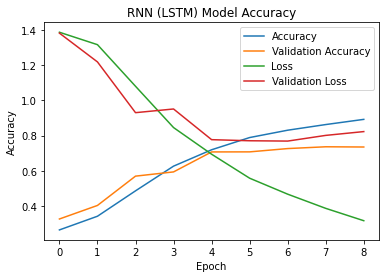

In [10]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history["loss"])
plt.plot(hist.history['val_loss'])
plt.title("RNN (LSTM) Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
plt.show()
#plt.savefig('rnn_lstm_acc.png')

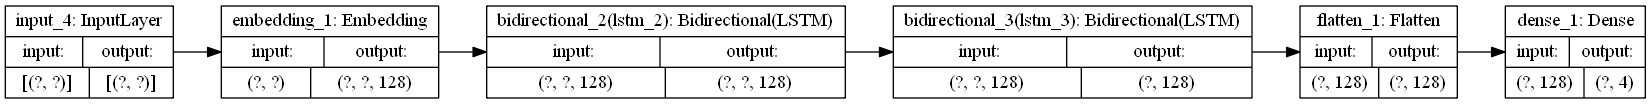

In [15]:
plot_model(lstm_model, rankdir='LR', show_shapes=True)

In [10]:
xception_model = keras.models.load_model('/content/trial_xception_1e-4_480x360.h5')

OSError: SavedModel file does not exist at: /content/trial_xception_1e-4_480x360.h5/{saved_model.pbtxt|saved_model.pb}

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = lstm_model.predict(X_test)
y_preds = np.argmax(y_pred, axis=1)
accuracy_score(y_test, y_preds)

print

0.7445687952600395

In [12]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

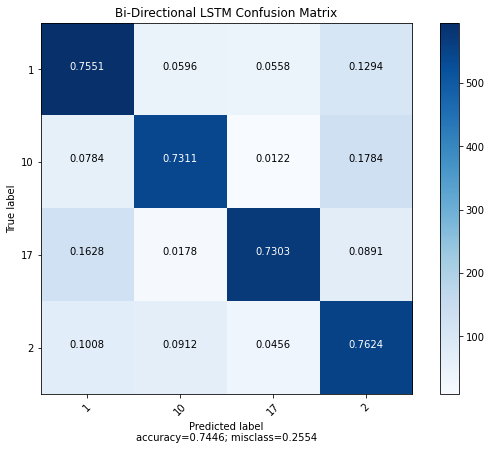

In [14]:
cm = confusion_matrix(y_test, y_preds)
plot_confusion_matrix(cm, ['1', '10', '17', '2'], title='Bi-Directional LSTM Confusion Matrix')